# 알고리즘들을 사용하여 'spaceship-titanic' 모델의 성능을 비교해보자.

## 데이터 준비

In [48]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option("display.max_rows", 200)

In [49]:
df_train = pd.read_csv("./spaceship-titanic/train.csv")
df_test = pd.read_csv("./spaceship-titanic/test.csv")

## 데이터 확인

### 데이터 결측치 확인

In [50]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [51]:
df_ana = df_train.copy()

# data type에 맞게 남은 결측값 채워넣기.
for col_name in df_train.columns:
    if df_ana[col_name].dtype == "float64":
        df_ana[col_name].fillna(df_ana[col_name].mean(), inplace=True)
    if df_ana[col_name].dtype == "object":
        df_ana[col_name].fillna(df_ana[col_name].mode()[0], inplace=True)

# 결측값이 채워졌는지 확인.
df_ana.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

### 데이터 내용 확인

In [52]:
df_ana

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


| 열 이름       | 설명                                                                       |
|--------------|----------------------------------------------------------------------------|
| PassengerId  | 각 승객의 고유ID. 형식은 gggg(그룹)_pp(그룹 내 번호). 그룹은 주로 가족 단위. |
| HomePlanet   | 승객이 출발한 행성. 일반적으로 영구 거주지의 행성을 나타냄.                              |
| CryoSleep    | 승객의 여행기간 중 냉동수면 여부. 냉동수면 상태의 승객은 Cabin 안에만 위치.                  |
| Cabin        | 승객이 머무는 캐빈 번호. deck/num/side 형식을 취하며, side는 P(항구) or S(항로).               |
| Destination  | 승객이 하선할 행성.                                                         |
| Age          | 승객의 나이.                                                                   |
| VIP          | 승객의 항해 중 특별 VIP 서비스 결제 여부.                                       |
| RoomService  | 승객이 스페이스쉽 타이타닉의 해당 고급 편의시설에서 사용한 금액.                                     |
| FoodCourt    | 승객이 스페이스쉽 타이타닉의 해당 고급 편의시설에서 사용한 금액.                                     |
| ShoppingMall | 승객이 스페이스쉽 타이타닉의 해당 고급 편의시설에서 사용한 금액.                                     |
| Spa          | 승객이 스페이스쉽 타이타닉의 해당 고급 편의시설에서 사용한 금액.                                     |
| VRDeck       | 승객이 스페이스쉽 타이타닉의 해당 고급 편의시설에서 사용한 금액.                                     |
| Name         | 승객의 이름.                                                            |
| Transported  | 승객의 다른 차원 이동여부. (예측 대상)                                 |


## 가설

1. 나이대에 따라 생존율이 다를 것이다.
2. 'VIP'여부에 따라 생존율이 다를 것이다.
3. 'RoomService', 'FoodCourt'와 같은 고급 편의시설 이용자들 중에서도 더 많은 돈을 쓴 사람들이 더 많이 생존하였을 것이다.
4. 'Cabin' 안에서 'Port'에 위치한 승객이 'Starboard'에 위치한 승객보다 더 많이 생존하였을 것이다.
5. 'Earth'에서 출발한 승객보다 다른 행성에서 출발한 승객이 더 많이 생존하였을 것이다.
6. 'CryoSleep' 상태의 승객들의 생존율이 높을 것이다.
7. 가장 많은 사람들이 향하는 'Destination'으로 가는 승객들의 생존율이 가장 낮을 것이다.

## 데이터 전처리 및 탐색적 데이터 분석(EDA)

### 가설 1. 미성년인 아이들이나 중년 이상의 생존비율이 청년들보다 높을 것이다.

#### 데이터 변환

In [53]:
age_columns = ['Transported', 'Age']
df_ana_age = df_ana[age_columns]
df_ana_age

,Transported,Age
0,False,39.0
1,True,24.0
2,False,58.0
3,False,33.0
4,True,16.0
...,...,...
8688,False,41.0
8689,False,18.0
8690,True,26.0
8691,False,32.0


#### 시각화

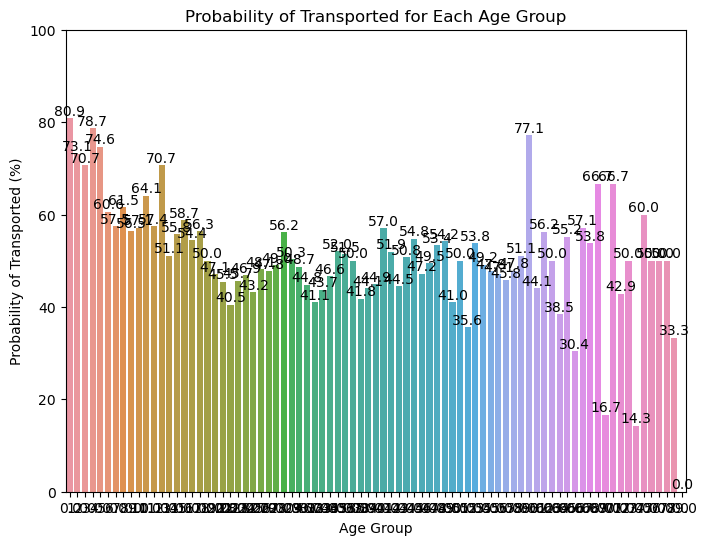

In [54]:
Age_transported = df_ana_age.groupby('Age')['Transported'].mean() * 100

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=Age_transported.index, y=Age_transported.values)
plt.title('Probability of Transported for Each Age Group')
plt.xlabel('Age Group')
plt.ylabel('Probability of Transported (%)')
plt.ylim(0, 100)  # y축 범위 설정
# 각 막대 위에 숫자로 확률 표시
for index, value in enumerate(Age_transported):
    barplot.annotate(f'{value:.1f}', xy=(index, value), ha='center', va='bottom', fontsize=10)
plt.show()

In [55]:
df_ana_age_corr = pd.get_dummies(df_ana_age)
df_ana_age_corr.corr()

,Transported,Age
Transported,1.000000,-0.074249
Age,-0.074249,1.000000


17세 이하 미성년자들의 생존률이 제일 높았으며, 나이가 들어갈 수록 생존율이 들쭉날쭉한 것을 볼 수 있다.\
하지만 청년층, 중장년층의 생존율의 평균이 비슷하고, 상관관계도 낮으므로 미성년자인가 아닌가로 열을 수정할 것이다.

#### 열 최종 수정

In [56]:
df_ana_age['Age'] = df_ana_age['Age'].apply(lambda x: 'Underage' if x <= 17 else 'not_Underage')
df_ana_age

/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/2422201579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ana_age['Age'] = df_ana_age['Age'].apply(lambda x: 'Underage' if x <= 17 else 'not_Underage')


,Transported,Age
0,False,not_Underage
1,True,not_Underage
2,False,not_Underage
3,False,not_Underage
4,True,Underage
...,...,...
8688,False,not_Underage
8689,False,not_Underage
8690,True,not_Underage
8691,False,not_Underage


### 가설 2. 'VIP'여부에 따라 생존율이 다를 것이다.

#### 데이터 변환

In [57]:
vip_columns = ['Transported', 'VIP']
df_ana_VIP = df_ana[vip_columns]
df_ana_VIP

,Transported,VIP
0,False,False
1,True,False
2,False,True
3,False,False
4,True,False
...,...,...
8688,False,True
8689,False,False
8690,True,False
8691,False,False


#### 데이터 시각화

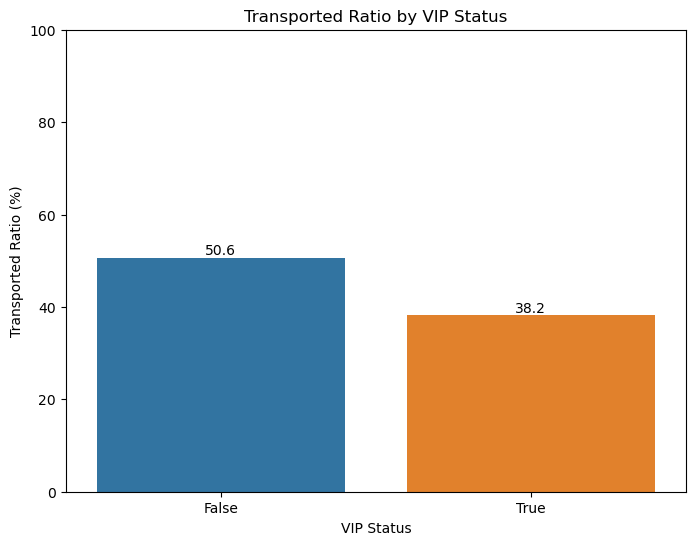

In [58]:
# 'VIP' 열의 값에 따른 'Transported' 비율 계산
VIP_transported = df_ana_VIP.groupby('VIP')['Transported'].mean() * 100

# 차트 그리기
plt.figure(figsize=(8, 6))
sns.barplot(x=VIP_transported.index, y=VIP_transported.values)
plt.title('Transported Ratio by VIP Status')
plt.xlabel('VIP Status')
plt.ylabel('Transported Ratio (%)')
plt.ylim(0, 100)  # y축 범위 설정
# 각 막대 위에 숫자로 확률 표시
for i, v in enumerate(VIP_transported):
    plt.text(x = i, y = v, s = f'{v:.1f}', ha = 'center', va = 'bottom', color = 'black', fontsize = 10)
plt.show()

In [59]:
df_ana_VIP_corr = pd.get_dummies(df_ana_VIP)
df_ana_VIP_corr.corr()

,Transported,VIP
Transported,1.000000,-0.037261
VIP,-0.037261,1.000000


결과적으로 VIP일때 오히려 생존율이 더 낮다는 것을 알 수 있었다.\
다만, 상관관계가 큰 항목은 아니다.

### 가설 3. 'RoomService', 'FoodCourt' 등과 같은 고급 편의시설에서 한번이라도 돈을 쓴 사람들이 더 많이 생존하였을 것이다.


#### 데이터 변환

In [60]:
noble_columns = ['Transported','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_ana_noble = df_ana[noble_columns]
df_ana_noble_2 = df_ana_noble.copy()    # 뒤쪽의 분포도 검사를 위해 복사본 제작
df_ana_noble

,Transported,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,False,0.0,0.0,0.0,0.0,0.0
1,True,109.0,9.0,25.0,549.0,44.0
2,False,43.0,3576.0,0.0,6715.0,49.0
3,False,0.0,1283.0,371.0,3329.0,193.0
4,True,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,False,0.0,6819.0,0.0,1643.0,74.0
8689,False,0.0,0.0,0.0,0.0,0.0
8690,True,0.0,0.0,1872.0,1.0,0.0
8691,False,0.0,1049.0,0.0,353.0,3235.0


In [61]:
value_to_bool_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_ana_noble[value_to_bool_cols] = df_ana_noble[value_to_bool_cols].applymap(lambda x: True if x > 0 else False)

df_ana_noble

/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/3843612933.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ana_noble[value_to_bool_cols] = df_ana_noble[value_to_bool_cols].applymap(lambda x: True if x > 0 else False)
/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/3843612933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ana_noble[value_to_bool_cols] = df_ana_noble[value_to_bool_cols].applymap(lambda x: True if x > 0 else False)


,Transported,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,False,False,False,False,False,False
1,True,True,True,True,True,True
2,False,True,True,False,True,True
3,False,False,True,True,True,True
4,True,True,True,True,True,True
...,...,...,...,...,...,...
8688,False,False,True,False,True,True
8689,False,False,False,False,False,False
8690,True,False,False,True,True,False
8691,False,False,True,False,True,True


#### 데이터 시각화

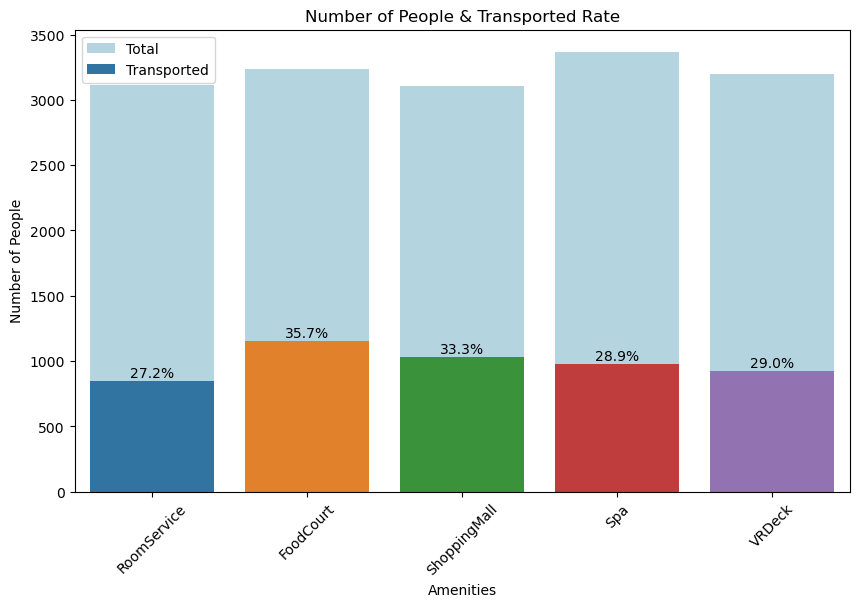

In [62]:
# 각 열의 사람 수 계산
noble_counts = df_ana_noble.drop(columns='Transported').sum()


# 'Transported'가 True인 사람 수 계산
noble_transported_counts = df_ana_noble[df_ana_noble['Transported'] == True].drop(columns='Transported').sum()
# 각 열에서 'Transported'가 True인 사람의 비율 계산
noble_transported_ratios = (noble_transported_counts / noble_counts) * 100

# 차트 그리기
plt.figure(figsize=(10, 6))
# 각 열의 사람 수에 대한 막대 그래프 그리기
ax = sns.barplot(x=noble_counts.index, y=noble_counts.values, color='lightblue', label='Total')
# 'Transported'가 True인 사람 수에 대한 그래프 겹치기
ax = sns.barplot(x=noble_transported_counts.index, y=noble_transported_counts.values, label='Transported')

plt.title('Number of People & Transported Rate')
plt.xlabel('Amenities')
plt.ylabel('Number of People')
plt.legend()
plt.xticks(rotation=45)

# 각 열에서 'Transported'가 True인 사람의 비율 텍스트로 표시
for i in range(len(noble_counts)):
    plt.text(i, noble_transported_counts.values[i] + 5, f'{noble_transported_ratios.values[i]:.1f}%', ha='center', va='bottom')

plt.show()

In [63]:
df_ana_noble.corr()

,Transported,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Transported,1.000000,-0.347021,-0.226647,-0.255067,-0.340826,-0.326147
RoomService,-0.347021,1.000000,0.248946,0.435340,0.303003,0.237620
FoodCourt,-0.226647,0.248946,1.000000,0.233593,0.454957,0.464413
ShoppingMall,-0.255067,0.435340,0.233593,1.000000,0.307592,0.244599
Spa,-0.340826,0.303003,0.454957,0.307592,1.000000,0.428242
VRDeck,-0.326147,0.237620,0.464413,0.244599,0.428242,1.000000


고급 편의시설을 한번이라도 이용한 사람들의 생존율은 25프로 밑으로 낮은 편이다.\
모든 항목 중 상관관계가 가장 높은 RoomService로 대표한다.

### 가설 4. Cabin 안에서 Port에 위치한 승객이 Starboard에 위치한 승객보다 더 많이 생존하였을 것이다.

In [64]:
Cabin_columns = ['Transported', 'Cabin']
df_ana_Cabin = df_ana[Cabin_columns]
df_ana_Cabin

,Transported,Cabin
0,False,B/0/P
1,True,F/0/S
2,False,A/0/S
3,False,A/0/S
4,True,F/1/S
...,...,...
8688,False,A/98/P
8689,False,G/1499/S
8690,True,G/1500/S
8691,False,E/608/S


'Cabin' 열을 분석하기 쉽게 'deck', 'sit_number', 'side' 세개의 열로 나눈다.

In [65]:
# 'Cabin' 열을 분할하여 새로운 열로 추가
df_ana_Cabin[['deck', 'sit_number', 'side']] = df_ana_Cabin['Cabin'].str.split('/', expand=True)

df_ana_Cabin = df_ana_Cabin.drop(columns='Cabin')


/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/1296997735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ana_Cabin[['deck', 'sit_number', 'side']] = df_ana_Cabin['Cabin'].str.split('/', expand=True)
/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/1296997735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ana_Cabin[['deck', 'sit_number', 'side']] = df_ana_Cabin['Cabin'].str.split('/', expand=True)
/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/

여기서, 결측값을 제거할 때 숫자값에 대해 평균값으로 채워버렸으므로 'sit_number'에 대한 값을 폐기한다.

In [66]:
df_ana_Cabin = df_ana_Cabin.drop(columns='sit_number')
df_ana_Cabin

,Transported,deck,side
0,False,B,P
1,True,F,S
2,False,A,S
3,False,A,S
4,True,F,S
...,...,...,...
8688,False,A,P
8689,False,G,S
8690,True,G,S
8691,False,E,S


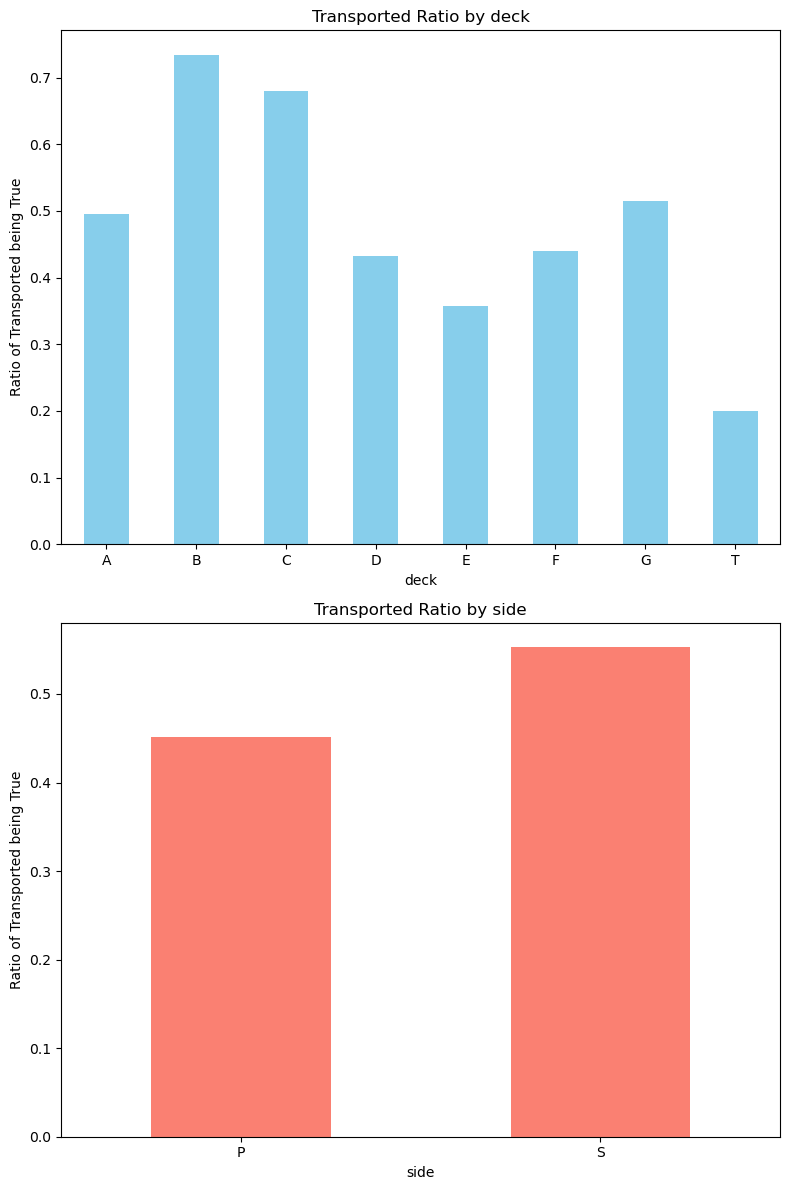

In [67]:
# 각 열에 대해 'Transported' 값이 True인 비율 계산
true_ratios_deck = df_ana_Cabin.groupby('deck')['Transported'].mean()
true_ratios_side = df_ana_Cabin.groupby('side')['Transported'].mean()

# 그래프 그리기
plt.figure(figsize=(8, 12))

# 'deck'에 대한 그래프
plt.subplot(2, 1, 1)
true_ratios_deck.plot(kind='bar', color='skyblue')
plt.title("Transported Ratio by deck")
plt.xlabel("deck")
plt.ylabel("Ratio of Transported being True")
plt.xticks(rotation=0)

# 'side'에 대한 그래프
plt.subplot(2, 1, 2)
true_ratios_side.plot(kind='bar', color='salmon')
plt.title("Transported Ratio by side")
plt.xlabel("side")
plt.ylabel("Ratio of Transported being True")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [68]:
df_ana_Cabin_corr = pd.get_dummies(df_ana_Cabin)
df_ana_Cabin_corr.corr()

,Transported,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S
Transported,1.000000,-0.002623,0.144733,0.108193,-0.034046,-0.097965,-0.087753,0.015822,-0.014568,-0.101397,0.101397
deck_A,-0.002623,1.000000,-0.054651,-0.053409,-0.042018,-0.058312,-0.119881,-0.118744,-0.004179,-0.009344,0.009344
deck_B,0.144733,-0.054651,1.000000,-0.096196,-0.075680,-0.105027,-0.215921,-0.213874,-0.007527,-0.019269,0.019269
deck_C,0.108193,-0.053409,-0.096196,1.000000,-0.073960,-0.102640,-0.211013,-0.209013,-0.007355,-0.016777,0.016777
deck_D,-0.034046,-0.042018,-0.075680,-0.073960,1.000000,-0.080750,-0.166010,-0.164436,-0.005787,0.016890,-0.016890
deck_E,-0.097965,-0.058312,-0.105027,-0.102640,-0.080750,1.000000,-0.230386,-0.228202,-0.008031,0.003944,-0.003944
deck_F,-0.087753,-0.119881,-0.215921,-0.211013,-0.166010,-0.230386,1.000000,-0.469149,-0.016510,0.042467,-0.042467
deck_G,0.015822,-0.118744,-0.213874,-0.209013,-0.164436,-0.228202,-0.469149,1.000000,-0.016354,-0.028896,0.028896
deck_T,-0.014568,-0.004179,-0.007527,-0.007355,-0.005787,-0.008031,-0.016510,-0.016354,1.000000,0.015177,-0.015177
side_P,-0.101397,-0.009344,-0.019269,-0.016777,0.016890,0.003944,0.042467,-0.028896,0.015177,1.000000,-1.000000


1. deck의 경우, 'B', 'C', 'E', 'T'의 경우 생존율이 다른 항목보다 더 차이나므로 유지.\
    다른 항목의 경우 'etc'로 대체.
2. 'side'의 경우, 그대로 유지.

In [69]:
df_ana_Cabin['deck'] = df_ana_Cabin['deck'].apply(lambda x: x if x in ['B', 'C', 'E', 'T'] else 'etc')
df_ana_Cabin

,Transported,deck,side
0,False,B,P
1,True,etc,S
2,False,etc,S
3,False,etc,S
4,True,etc,S
...,...,...,...
8688,False,etc,P
8689,False,etc,S
8690,True,etc,S
8691,False,E,S


In [70]:
df_ana_Cabin_corr = pd.get_dummies(df_ana_Cabin)
df_ana_Cabin_corr.corr()

,Transported,deck_B,deck_C,deck_E,deck_T,deck_etc,side_P,side_S
Transported,1.000000,0.144733,0.108193,-0.097965,-0.014568,-0.093467,-0.101397,0.101397
deck_B,0.144733,1.000000,-0.096196,-0.105027,-0.007527,-0.507014,-0.019269,0.019269
deck_C,0.108193,-0.096196,1.000000,-0.102640,-0.007355,-0.495490,-0.016777,0.016777
deck_E,-0.097965,-0.105027,-0.102640,1.000000,-0.008031,-0.540980,0.003944,-0.003944
deck_T,-0.014568,-0.007527,-0.007355,-0.008031,1.000000,-0.038768,0.015177,-0.015177
deck_etc,-0.093467,-0.507014,-0.495490,-0.540980,-0.038768,1.000000,0.019341,-0.019341
side_P,-0.101397,-0.019269,-0.016777,0.003944,0.015177,0.019341,1.000000,-1.000000
side_S,0.101397,0.019269,0.016777,-0.003944,-0.015177,-0.019341,-1.000000,1.000000


### 가설 5. Earth에서 출발한 승객보다 다른 행성에서 출발한 승객이 더 많이 생존하였을 것이다.

In [71]:
HomePlanet_columns = ['Transported', 'HomePlanet']
df_ana_HomePlanet = df_ana[HomePlanet_columns]
df_ana_HomePlanet

,Transported,HomePlanet
0,False,Europa
1,True,Earth
2,False,Europa
3,False,Europa
4,True,Earth
...,...,...
8688,False,Europa
8689,False,Earth
8690,True,Earth
8691,False,Europa


In [72]:
Counter(df_ana_HomePlanet['HomePlanet'])

Counter({'Earth': 4803, 'Europa': 2131, 'Mars': 1759})

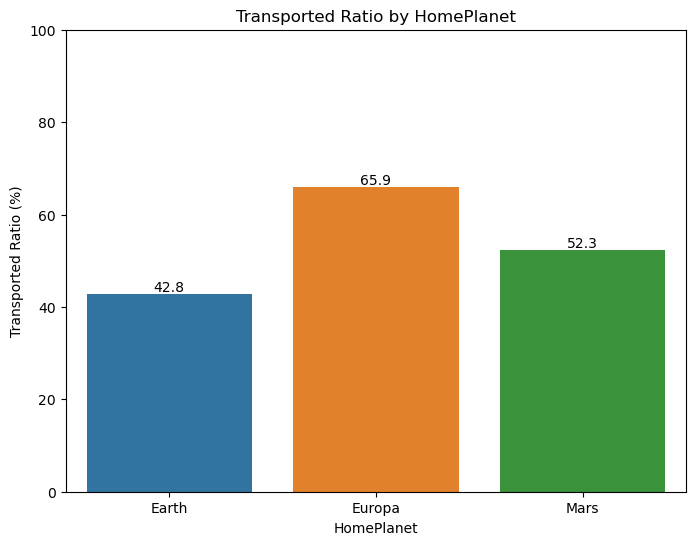

In [73]:
# 'HomePlanet' 열의 값에 따른 'Transported' 비율 계산
HomePlanet_transported = df_ana_HomePlanet.groupby('HomePlanet')['Transported'].mean() * 100

# 차트 그리기
plt.figure(figsize=(8, 6))
sns.barplot(x=HomePlanet_transported.index, y=HomePlanet_transported.values)
plt.title('Transported Ratio by HomePlanet')
plt.xlabel('HomePlanet')
plt.ylabel('Transported Ratio (%)')
plt.ylim(0, 100)  # y축 범위 설정
# 각 막대 위에 숫자로 확률 표시
for i, v in enumerate(HomePlanet_transported):
    plt.text(x = i, y = v, s = f'{v:.1f}', ha = 'center', va = 'bottom', fontsize = 10)
plt.show()

In [74]:
df_ana_HomePlanet_corr = pd.get_dummies(df_ana_HomePlanet)
df_ana_HomePlanet_corr.corr()

,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
Transported,1.000000,-0.168845,0.176916,0.019544
HomePlanet_Earth,-0.168845,1.000000,-0.633221,-0.559658
HomePlanet_Europa,0.176916,-0.633221,1.000000,-0.287022
HomePlanet_Mars,0.019544,-0.559658,-0.287022,1.000000


'Europa' 행성출신의 생존율이 가장 높은 것으로, 'Earth' 출신의 생존율이 가장 낮은 것으로 나타난다.

### 가설 6. 'CryoSleep' 상태의 승객들의 생존율이 높을 것이다.

In [75]:
CryoSleep_columns = ['Transported', 'CryoSleep']
df_ana_CryoSleep = df_ana[CryoSleep_columns]
df_ana_CryoSleep

,Transported,CryoSleep
0,False,False
1,True,False
2,False,False
3,False,False
4,True,False
...,...,...
8688,False,False
8689,False,True
8690,True,False
8691,False,False


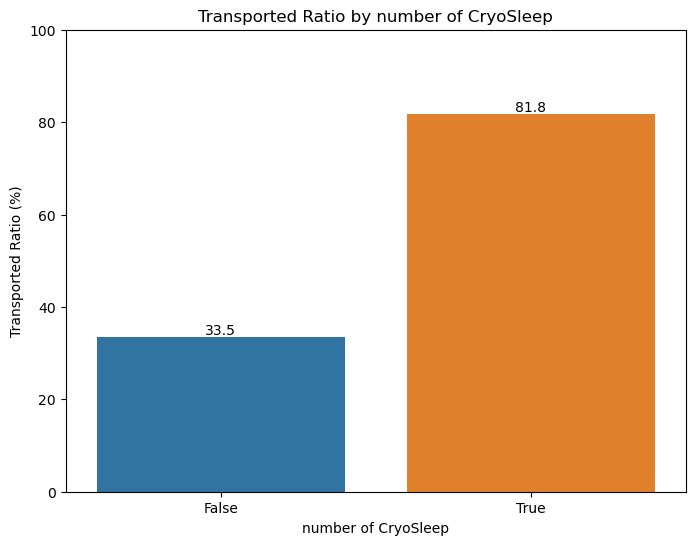

In [76]:
# 'CryoSleep' 열의 값에 따른 'Transported' 비율 계산
CryoSleep_transported = df_ana_CryoSleep.groupby('CryoSleep')['Transported'].mean() * 100

# 차트 그리기
plt.figure(figsize=(8, 6))
sns.barplot(x=CryoSleep_transported.index, y=CryoSleep_transported.values)
plt.title('Transported Ratio by number of CryoSleep')
plt.xlabel('number of CryoSleep')
plt.ylabel('Transported Ratio (%)')
plt.ylim(0, 100)  # y축 범위 설정
# 각 막대 위에 숫자로 확률 표시
for i, v in enumerate(CryoSleep_transported):
    plt.text(x = i, y = v, s = f'{v:.1f}', ha = 'center', va = 'bottom', fontsize = 10)
plt.show()

In [77]:
df_ana_CryoSleep_corr = pd.get_dummies(df_ana_CryoSleep)
df_ana_CryoSleep_corr.corr()

,Transported,CryoSleep
Transported,1.000000,0.460132
CryoSleep,0.460132,1.000000


가설대로 CryoSleep 상태의 승객들이 높은 생존율을 보였다.

### 가설 7. 가장 많은 사람들이 향하는 'Destination'으로 가는 승객들의 생존율이 가장 낮을 것이다.

In [78]:
Destination_columns = ['Transported','Destination']

df_ana_Destination = df_ana[Destination_columns]
df_ana_Destination

,Transported,Destination
0,False,TRAPPIST-1e
1,True,TRAPPIST-1e
2,False,TRAPPIST-1e
3,False,TRAPPIST-1e
4,True,TRAPPIST-1e
...,...,...
8688,False,55 Cancri e
8689,False,PSO J318.5-22
8690,True,TRAPPIST-1e
8691,False,55 Cancri e


In [79]:
Counter(df_ana_Destination['Destination'])

Counter({'TRAPPIST-1e': 6097, '55 Cancri e': 1800, 'PSO J318.5-22': 796})

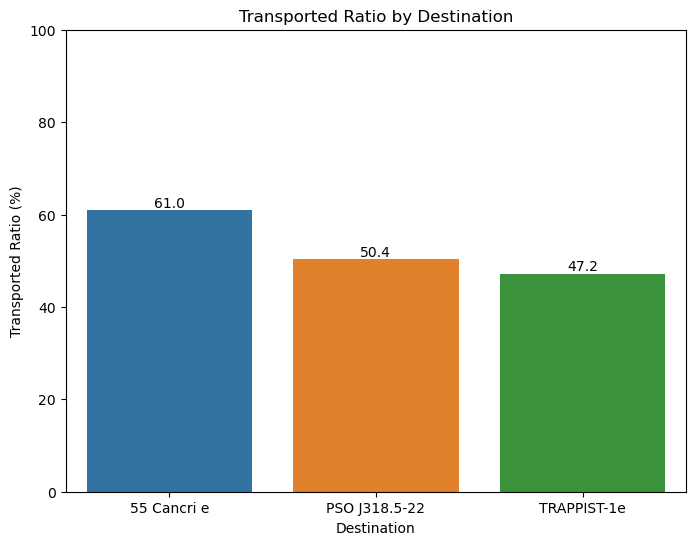

In [80]:
# 'HomePlanet' 열의 값에 따른 'Transported' 비율 계산
Destination_transported = df_ana_Destination.groupby('Destination')['Transported'].mean() * 100

# 차트 그리기
plt.figure(figsize=(8, 6))
sns.barplot(x=Destination_transported.index, y=Destination_transported.values)
plt.title('Transported Ratio by Destination')
plt.xlabel('Destination')
plt.ylabel('Transported Ratio (%)')
plt.ylim(0, 100)  # y축 범위 설정
# 각 막대 위에 숫자로 확률 표시
for i, v in enumerate(Destination_transported):
    plt.text(x = i, y = v, s = f'{v:.1f}', ha = 'center', va = 'bottom', fontsize = 10)
plt.show()

In [81]:
df_ana_Destination_corr = pd.get_dummies(df_ana_Destination)
df_ana_Destination_corr.corr()

,Transported,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
Transported,1.000000,0.108722,0.000092,-0.096319
Destination_55 Cancri e,0.108722,1.000000,-0.162240,-0.783137
Destination_PSO J318.5-22,0.000092,-0.162240,1.000000,-0.486554
Destination_TRAPPIST-1e,-0.096319,-0.783137,-0.486554,1.000000


사람들이 가장 많이 향하는 반대 순서로 생존율이 높았다.\
다만, 큰 변화를 보이진 않아 '55 Cancri e'외의 열은 'not_55 Cancri e'로 대체 가능할 것으로 보인다.

In [82]:
df_ana_Destination['Destination'] = df_ana_Destination['Destination'].apply(lambda x: x if x == '55 Cancri e' else 'not_55 Cancri e')
df_ana_Destination

/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/2716880836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ana_Destination['Destination'] = df_ana_Destination['Destination'].apply(lambda x: x if x == '55 Cancri e' else 'not_55 Cancri e')


,Transported,Destination
0,False,not_55 Cancri e
1,True,not_55 Cancri e
2,False,not_55 Cancri e
3,False,not_55 Cancri e
4,True,not_55 Cancri e
...,...,...
8688,False,55 Cancri e
8689,False,not_55 Cancri e
8690,True,not_55 Cancri e
8691,False,55 Cancri e


### 데이터 통합

In [83]:
y_value = df_train.pop("Transported")
df_all = pd.concat([df_train, df_test], axis=0)
df_all = df_all.reset_index(drop=True)
df_all

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [84]:
# 사람의 생존여부와 관계없는 'PassengerId', 'Name' 열은 제거.
PassengerId = df_all.pop('PassengerId')
Name = df_all.pop('Name')

In [85]:
# 가설 1에 대한 전처리
df_all['Age'] = df_all['Age'].apply(lambda x: 'Underage' if x <= 17 else 'not_Underage')
Age = df_all.pop('Age')

# 가설 2에 대한 전처리
df_all['VIP'] = df_all['VIP'].astype(bool)

# 가설 3에 대한 전처리
df_all[value_to_bool_cols] = df_all[value_to_bool_cols].applymap(lambda x: True if x > 0 else False)

# 가설 4에 대한 전처리
df_all[['deck', 'sit_number', 'side']] = df_all['Cabin'].str.split('/', expand=True)
df_all = df_all.drop(columns='Cabin')
df_all = df_all.drop(columns='sit_number')
df_all['deck'] = df_all['deck'].apply(lambda x: x if x in ['B', 'C', 'E', 'T'] else 'etc')

# 가설 7에 대한 전처리
df_all['Destination'] = df_all['Destination'].apply(lambda x: x if x == '55 Cancri e' else 'not_55 Cancri e')

# 가설 5, 6, 7에 대한 전처리
# -> One-hot encoding 필요.
OneHot_columns = ['deck', 'side', 'HomePlanet', 'CryoSleep', 'Destination']
df_all_encoding = pd.get_dummies(df_all[OneHot_columns])
df_all = pd.concat([df_all, df_all_encoding], axis=1)
df_all = df_all.drop(columns=OneHot_columns)
df_all

/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/4211108017.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all[value_to_bool_cols] = df_all[value_to_bool_cols].applymap(lambda x: True if x > 0 else False)


,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck_B,deck_C,deck_E,deck_T,deck_etc,side_P,side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_not_55 Cancri e
0,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,True
1,False,True,True,True,True,True,False,False,False,False,True,False,True,True,False,False,True,False,False,True
2,True,True,True,False,True,True,False,False,False,False,True,False,True,False,True,False,True,False,False,True
3,False,False,True,True,True,True,False,False,False,False,True,False,True,False,True,False,True,False,False,True
4,False,True,True,True,True,True,False,False,False,False,True,False,True,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,True
12966,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True
12967,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,True,True,False
12968,False,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,True,False,False,True


boolean 타입을 가진 17개의 column으로 이루어진 하나의 데이터셋을 만들었다.

### 상관관계 확인

#### Train 데이터에 대한 상관관계 확인

In [86]:
df_all_corr = pd.concat([y_value, df_all[:len(y_value)]], axis=1)
df_all_corr.corr()

,Transported,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck_B,deck_C,deck_E,...,deck_etc,side_P,side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_not_55 Cancri e
Transported,1.000000,-0.024602,-0.347928,-0.232816,-0.263792,-0.344050,-0.332175,0.144733,0.108193,-0.097965,...,-0.093467,-0.101397,0.101455,-0.169019,0.176916,0.019544,-0.451744,0.460132,0.108722,-0.108722
VIP,-0.024602,1.000000,0.037382,0.067434,0.017411,0.054186,0.048130,0.034473,0.049751,-0.019124,...,-0.040017,0.000545,-0.003610,-0.107343,0.094805,0.033617,0.050342,-0.051060,0.033471,-0.033471
RoomService,-0.347928,0.037382,1.000000,0.254211,0.451274,0.306595,0.250905,-0.142237,-0.093919,0.095546,...,0.085171,0.019440,-0.018367,0.011811,-0.193104,0.196851,0.516539,-0.523162,-0.070077,0.070077
FoodCourt,-0.232816,0.067434,0.254211,1.000000,0.248876,0.458940,0.478388,0.023896,0.124299,0.041823,...,-0.122989,-0.001755,0.003640,0.002529,0.184490,-0.202114,0.529887,-0.539264,0.027730,-0.027730
ShoppingMall,-0.263792,0.017411,0.451274,0.248876,1.000000,0.320504,0.251084,-0.126182,-0.093188,0.096438,...,0.074399,0.017500,-0.010005,0.041469,-0.190836,0.157071,0.514206,-0.518191,-0.083750,0.083750
Spa,-0.344050,0.054186,0.306595,0.458940,0.320504,1.000000,0.446503,-0.007945,0.091336,0.049920,...,-0.087409,0.003102,0.001165,-0.033788,0.123753,-0.091916,0.549843,-0.557356,0.003710,-0.003710
VRDeck,-0.332175,0.048130,0.250905,0.478388,0.251084,0.446503,1.000000,0.012924,0.109000,0.032674,...,-0.100268,0.009023,-0.008098,0.026415,0.153517,-0.193225,0.527444,-0.533288,0.021326,-0.021326
deck_B,0.144733,0.034473,-0.142237,0.023896,-0.126182,-0.007945,0.012924,1.000000,-0.096196,-0.105027,...,-0.507014,-0.019269,0.033626,-0.332759,0.538379,-0.158020,-0.121837,0.124049,0.170658,-0.170658
deck_C,0.108193,0.049751,-0.093919,0.124299,-0.093188,0.091336,0.109000,-0.096196,1.000000,-0.102640,...,-0.495490,-0.016777,0.030809,-0.325196,0.525633,-0.154428,-0.031703,0.028433,0.164428,-0.164428
deck_E,-0.097965,-0.019124,0.095546,0.041823,0.096438,0.049920,0.032674,-0.105027,-0.102640,1.000000,...,-0.540980,0.003944,0.011385,-0.052634,-0.077058,0.145291,0.110477,-0.110644,-0.061667,0.061667


위에서 파악했던 항목들 중 대표될 만한 항목들 제외 후 최종 데이터셋 선정.

In [87]:
# final_columns = ['Underage', 'VIP', 'RoomService', 'Cabin_Port', 'HomePlanet_Europa', 'HomePlanet_Earth', \
#                  'CryoSleep_True', 'Destination_55 Cancri e']
# df_all = df_all[final_columns]

### 최종 정리된 데이터셋

In [88]:
df_all

,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck_B,deck_C,deck_E,deck_T,deck_etc,side_P,side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_not_55 Cancri e
0,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,True
1,False,True,True,True,True,True,False,False,False,False,True,False,True,True,False,False,True,False,False,True
2,True,True,True,False,True,True,False,False,False,False,True,False,True,False,True,False,True,False,False,True
3,False,False,True,True,True,True,False,False,False,False,True,False,True,False,True,False,True,False,False,True
4,False,True,True,True,True,True,False,False,False,False,True,False,True,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,True
12966,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True
12967,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,True,True,False
12968,False,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,True,False,False,True


### 데이터셋 분리

In [89]:
from sklearn.model_selection import train_test_split

df_all_train = df_all[:len(y_value)]
df_all_test = df_all[len(y_value):]
X_train, X_val, y_train, y_val = train_test_split(df_all_train, y_value, train_size=0.8, test_size=0.2, random_state=0)

## 모델 선택 및 훈련

### 1. Linear Regression

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

print('r2값:', r2_score(lr.predict(X_val), y_val))
print('mse:', mean_squared_error(lr.predict(X_val),  y_val))

r2값: -1.4494547068804398
mse: 0.17835677499535305


r2값과 mse 결과가 좋지 않다.\
현재 우리가 사용하는 데이터는 분류 문제로써, \
연속형 데이터 예측에 적합한 Linear Regression은 적합하지 않다는 것을 알 수 있다.

### 2. Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0).fit(X_train.values, y_train)
print('accuracy:', accuracy_score(clf.predict(X_val.values), y_val))

accuracy: 0.745830937320299


### 3. Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 모델 학습
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_val)

# 성능 평가
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7274295572167913


### 4. Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 모델 학습
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_val)

# 성능 평가
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7303047728579644


### 5. XGBoost

In [94]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 모델 학습
model = XGBClassifier()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_val)

# 성능 평가
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7354801610120759


### 정확도 확인.

예측이 낮은 Linear Regression을 제외,  Logistic Regression, Decision Tree, Random Forest, XGBoost의 정확도를 확인해본 결과, /
Logistic Regression의 정확도가 약 74.5%로 그나마 가장 높았다.\
하지만, 모델이 단순히 작동한다고 생각하지 않아서 XGBoost를 이용해 세부적 조정을 통해 정확도를 상승시키려고 한다.

## 모델 튜닝 및 평가

### 세부 조절

optuna 사용해서 세부사항 조절.

In [95]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [96]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    # XGBoost 모델 생성
    model = XGBClassifier(**param)

    # 교차 검증을 통한 모델 평가
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

    return score

# Optuna를 사용한 하이퍼파라미터 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 확인
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# 최적의 하이퍼파라미터를 사용하여 최종 모델 학습
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)


/Users/cepheid/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-21 13:26:03,965] A new study created in memory with name: no-name-6fc55712-6496-40ad-ae00-f3585b4e01bc
/var/folders/7_/fgk7m2px25gg4lt93d4_xwy40000gp/T/ipykernel_2548/2036929965.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
[I 2024-03-21 13:26:04,564] Trial 0 finished with value: 0.7492090882945067 and parameters: {'max_depth': 5, 'learning_rate': 0.024306394478684303, 'n_estimators': 159, 'subsample': 0.9026680739663047, 'colsample_bytree': 0.6834449086666502}. Best is trial 0 w

Best Hyperparameters: {'max_depth': 4, 'learning_rate': 0.11289668128840566, 'n_estimators': 68, 'subsample': 0.8107816281096072, 'colsample_bytree': 0.9224143724063265}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9224143724063265, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11289668128840566,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=68, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [97]:
print("Best hyperparameters:", study.best_params)

print("Best objective value:", study.best_value)

print("Best trial:", study.best_trial)

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.11289668128840566, 'n_estimators': 68, 'subsample': 0.8107816281096072, 'colsample_bytree': 0.9224143724063265}
Best objective value: 0.7528041415012942
Best trial: FrozenTrial(number=3, state=1, values=[0.7528041415012942], datetime_start=datetime.datetime(2024, 3, 21, 13, 26, 7, 151606), datetime_complete=datetime.datetime(2024, 3, 21, 13, 26, 7, 422088), params={'max_depth': 4, 'learning_rate': 0.11289668128840566, 'n_estimators': 68, 'subsample': 0.8107816281096072, 'colsample_bytree': 0.9224143724063265}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, st

optuna를 이용하여 세부 파라미터를 조절한 결과, 약 75.2%의 정확도를 얻을 수 있었다.